# Qiskit 6 - Extended Grover Implementation

1. Short description
2. Registers
3. State preperation
4. Toffolli$^N$ gate
5. Phase shift
6. Inversion about the mean
7. Execute on simulation
8. Execute on IBMQ

In [1]:
from qiskit import (
    QuantumRegister,
    ClassicalRegister,
    QuantumCircuit,
    Aer,
    execute,
    IBMQ)

from qiskit.tools.visualization import (
    circuit_drawer,
    plot_histogram)

## 1 - Short description

#### Number of qubits
We will extend the implementation to 5 computational qubits. In order to successfully be able to implement a Toffolli gate with 5 controll units, we will also need 4 ancillary qubits.

#### Number of states
The space **s** of possible outcome states where N = 5 is:

$${\bf s} = \sqrt{2^N} = \sqrt{2^5} = 32$$

The bitstring is of length 5, hence item we are looking for, **a**, is an integer in the set $\mathbb N_{0-31}$.

#### Number of iterations
$$iterations = \sqrt2^N = \sqrt2^5 = \sqrt32 \approx 5,6568$$

#### Expectations
Expect vanishing results on the IBMQ due to the increased number of quantum gates in the circuit, and the compound of errors that comes with that.

## 2 - Registers

Let **x** = computational qubits = $|\bf {x} \rangle_{0-4}$,

and let **y** = ancilla qubits = $|\bf {y} \rangle_{0-2}$ where $|\bf {y} \rangle_{2}$ is the target unit.

In [7]:
x = QuantumRegister(5, 'x')
y = QuantumRegister(4, 'y')
c = ClassicalRegister(5, 'c')

## 3 - State preperation

Big question for the state preperation is how to deal with the extra ancilla qubits, assuming a full layer of hadamards, are we to:

* treat all ancillary alike and flip them before hadamard?
* is this to be done inside the iteration loop for all of them?
* reset some of them?

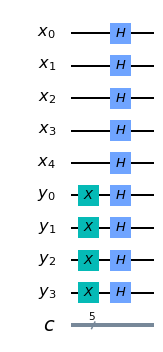

In [40]:
s = QuantumCircuit(x, y, c)
s.barrier(x)
s.x(y)
s.h(x)
s.h(y)
s.barrier()
circuit_drawer(s, output='mpl', plot_barriers=False, scale=0.5)

## 4 - The Toffolli gate

We will construct a 5 computational qubit Toffolli gate from a set of $C_{not}$ gates. 

On a first go with the purpose of being executed in a simulator we will throw up the gates straight out of the blueprint. However, in order to be executed on a quantum computer we ought to be prepared to tailor the wiring and connection of the $C_{not}$ gates such that it corresponds to the qubit connections on the actual hardware.

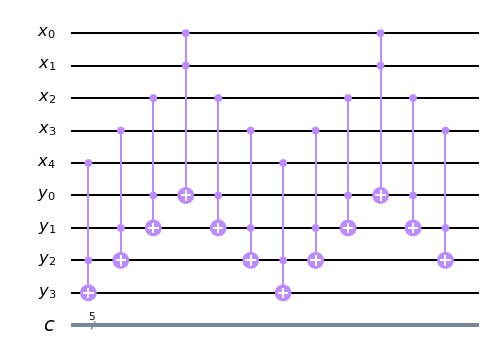

In [41]:
T = QuantumCircuit(x, y, c)
T.barrier()
T.ccx(y[2], x[4], y[3])
T.barrier()
T.ccx(y[1], x[3], y[2])
T.barrier()
T.ccx(y[0], x[2], y[1])
T.barrier()
T.ccx(x[0], x[1], y[0])
T.barrier()
T.ccx(y[0], x[2], y[1])
T.barrier()
T.ccx(y[1], x[3], y[2])
T.barrier()
T.ccx(y[2], x[4], y[3])
T.barrier()
T.ccx(y[1], x[3], y[2])
T.barrier()
T.ccx(y[0], x[2], y[1])
T.barrier()
T.ccx(x[0], x[1], y[0])
T.barrier()
T.ccx(y[0], x[2], y[1])
T.barrier()
T.ccx(y[1], x[3], y[2])
T.barrier()
circuit_drawer(T, output='mpl', plot_barriers=False, scale=0.5)

Lets create a test state and measure the target qubit to see if the gate functions as it is supposed to.

The result below tells us that while all the computational qubits are flipped into a state of $|{\bf x} | 1 \rangle$, we can measure the target qubit being in the state$|y_3 | 1 \rangle$ 100% of the times.

Good, lets build on this Toffolli gate and construct our unitary **W**.

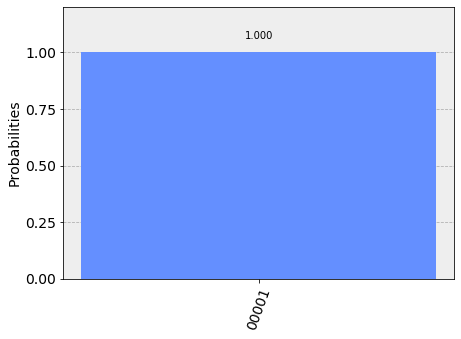

In [28]:
test_T = QuantumCircuit(x, y, c)
test_T.x(x)
test_T += T
test_T.measure(y[3], c[0])
count_test_T = execute(test_T, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(count_test_T)

## 5 - Phase shift

Let the item we are looking for be:

$${\bf a} = 24 = 11000$$

Let furthermore the Toffolli gate be sandwiched by Pauli X gates such that they correspond with the zeros in the bitstring. Hence we place bitflips on the computational qubits $|x\rangle_{2-4}$.

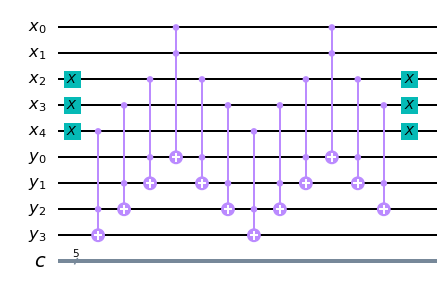

In [45]:
W = QuantumCircuit(x, y, c)
W.x([x[2], x[3], x[4]])
W += T
W.x([x[2], x[3], x[4]])
circuit_drawer(W, output='mpl', plot_barriers=False, scale=0.4)

## 6 - Inversion about the mean

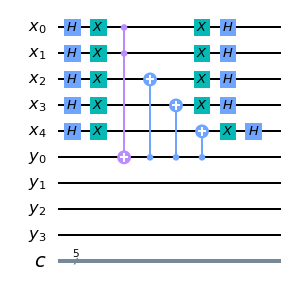

In [101]:
V = QuantumCircuit(x, y, c)
V.barrier()
V.h(x)
V.x(x)
V.barrier()
V.ccx(x[0], x[1], y[0])
V.barrier()
V.cx(y[0], x[2])
V.barrier()
V.cx(y[0], x[3])
V.barrier()
V.cx(y[0], x[4])
V.x(x)
V.h(x)
V.barrier()
circuit_drawer(V, output='mpl', plot_barriers=False, scale=0.4)

## 7 - Execute on simulation

**Comments:** 

* After switchting around the circuit in the **V** operator the results below on 7 iterations are the first ones obtained that have our selected item, 11000, as its prime choice, or at least repeatedly among the top ones.

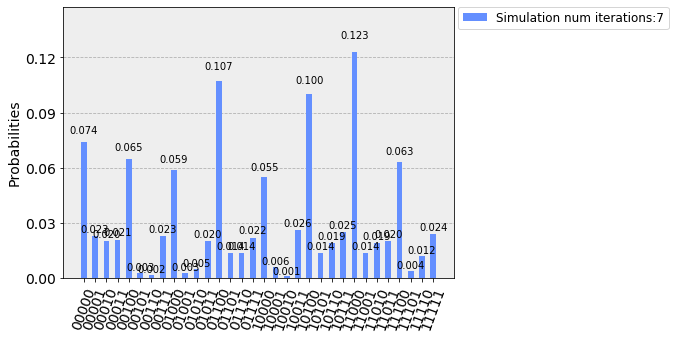

In [108]:
sim = Aer.get_backend('qasm_simulator')
num_iterations = 7
G = QuantumCircuit(x, y, c)
for iteration in range(num_iterations):
    G += s + W + V
G.measure(x, c)
count = execute(G, sim, shots=1000).result().get_counts()
plot_histogram(count, legend=['Simulation num iterations:' + str(num_iterations)])

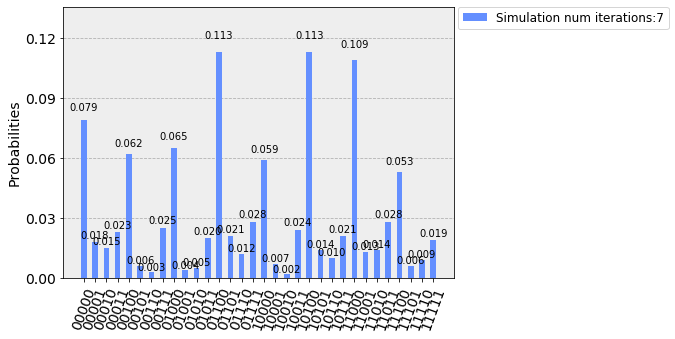

In [126]:
sim = Aer.get_backend('qasm_simulator')
num_iterations = 7
G = QuantumCircuit(x, y, c)
for iteration in range(num_iterations):
    G += s + W + V
G.measure(x, c)
count = execute(G, sim, shots=1000).result().get_counts()
plot_histogram(count, legend=['Simulation num iterations:' + str(num_iterations)])

## 8 - Execution on a quantum computer

Gonna run a quick try on the melbourne core.

Interestingly enough, it worked. When it comes to result though it is quite meshed as we can see. Wether or not that has to do with accumulated error-rates in this deeper Grover circuit, or if it has to do with our perhaps not fulfilled exellency of architecture design will have to be further explored down the road.

Now lets move on to Shores.

In [128]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_16_melbourne')

/home/mikael/.local/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


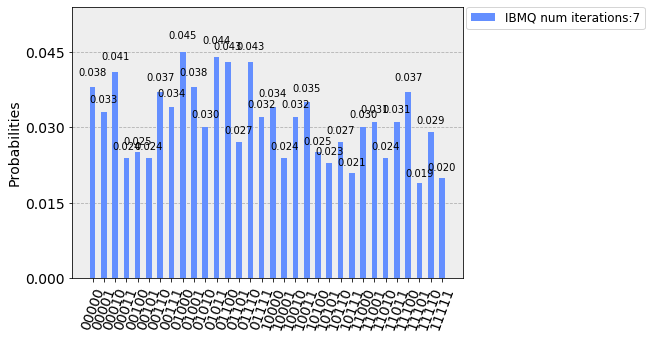

In [129]:
num_iterations = 7
G = QuantumCircuit(x, y, c)
for iteration in range(num_iterations):
    G += s + W + V
G.measure(x, c)
count = execute(G, backend, shots=1000).result().get_counts()
plot_histogram(count, legend=['IBMQ num iterations:' + str(num_iterations)])

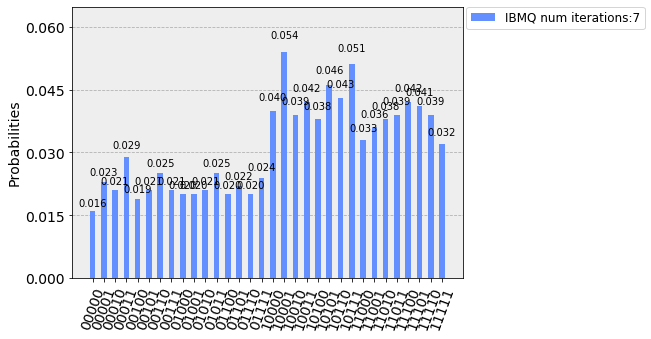

In [130]:
num_iterations = 7
G = QuantumCircuit(x, y, c)
for iteration in range(num_iterations):
    G += s + W + V
G.measure(x, c)
count = execute(G, backend, shots=1000).result().get_counts()
plot_histogram(count, legend=['IBMQ num iterations:' + str(num_iterations)])

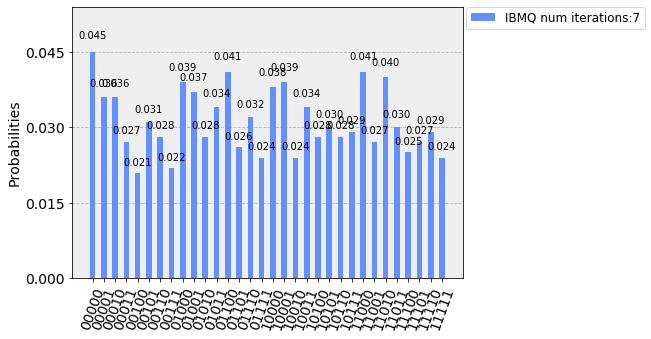

In [131]:
num_iterations = 7
G = QuantumCircuit(x, y, c)
for iteration in range(num_iterations):
    G += s + W + V
G.measure(x, c)
count = execute(G, backend, shots=1000).result().get_counts()
plot_histogram(count, legend=['IBMQ num iterations:' + str(num_iterations)])

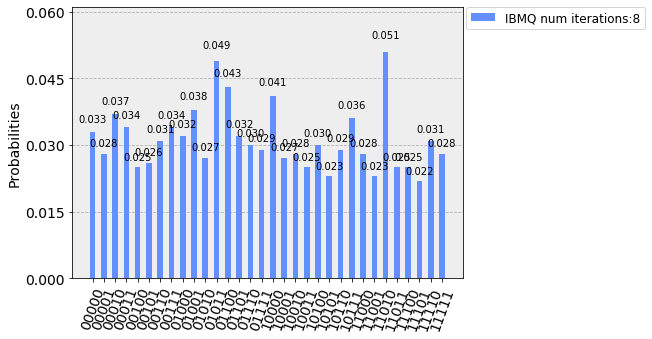

In [132]:
num_iterations = 8
G = QuantumCircuit(x, y, c)
for iteration in range(num_iterations):
    G += s + W + V
G.measure(x, c)
count = execute(G, backend, shots=1000).result().get_counts()
plot_histogram(count, legend=['IBMQ num iterations:' + str(num_iterations)])